# 4-Peaks

In [1]:
title='4-Peaks'

In [2]:
import mlrose_hiive

import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
eval_count = 0

def four_peaks(state):
    global eval_count
    
    fitness = mlrose_hiive.FourPeaks(t_pct=0.15)
    
    eval_count += 1
    
    return fitness.evaluate(state)

ffn_4peaks = mlrose_hiive.CustomFitness(four_peaks)

print(four_peaks(np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0])))

30


In [127]:
np.random.seed(1)
input_size = [10, 20, 25, 50]

eval_cnt_df = pd.DataFrame()
eval_cnt_df['input_size'] = input_size
eval_cnt_rhc = []
eval_cnt_sa = []
eval_cnt_ga = []
eval_cnt_mimic = []

eval_time_df = pd.DataFrame()
eval_time_df['input_size'] = input_size
eval_time_rhc = []
eval_time_sa = []
eval_time_ga = []
eval_time_mimic = []

fitness_curve = {}

for n in input_size:
    np.random.seed(1)    
    ## initialize problem
    ffn_4peaks = mlrose_hiive.CustomFitness(four_peaks)
    
    ## all algorithm start from same state
    init_state = np.random.randint(2, size=n)
    problem = mlrose_hiive.DiscreteOpt(length=len(init_state), fitness_fn=ffn_4peaks, 
                                       maximize=True, max_val=2)
    
    print('Custom 4peaks:', ffn_4peaks.evaluate(init_state))
    
    ## Random Hill Climbing
    eval_count = 0
    begin = datetime.now()
    rhc_state, rhc_fitness, rhc_curve = mlrose_hiive.random_hill_climb(problem, 
                                                                       max_attempts=200, 
                                                                       max_iters=6000,
                                                                       restarts=200,
                                                                       init_state=init_state,
                                                                       curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_rhc.append(dt.total_seconds())
    eval_cnt_rhc.append(eval_count)

    ## Simulated Annealing
    eval_count = 0
    schedule = mlrose_hiive.ExpDecay(init_temp=5.0) ## Simulated Annealing
    begin = datetime.now()
    sa_state, sa_fitness, sa_curve = mlrose_hiive.simulated_annealing(problem,
                                                                      schedule=schedule,
                                                                      max_attempts=100, 
                                                                      max_iters=4096, 
                                                                      init_state=init_state,
                                                                      curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_sa.append(dt.total_seconds())
    eval_cnt_sa.append(eval_count)
    
    ## Genetic Algorithm
    eval_count = 0
    pop_size = 100
    mute_prob = 0.1
    begin = datetime.now()
    ga_state, ga_fitness, ga_curve =  mlrose_hiive.genetic_alg(problem, 
                                                               pop_size=pop_size,
                                                               mutation_prob=mute_prob, 
                                                               max_attempts=200,
                                                               max_iters=256,
                                                               curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_ga.append(dt.total_seconds())
    eval_cnt_ga.append(eval_count)
    
    ## MIMIC
    eval_count = 0
    pop_size = 500
    keep_pct = 0.25
    begin = datetime.now()
    mimic_state, mimic_fitness, mimic_curve = mlrose_hiive.mimic(problem, 
                                                                 pop_size=pop_size,
                                                                 keep_pct=keep_pct, 
                                                                 max_attempts=100,
                                                                 max_iters=256,
                                                                 curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_mimic.append(dt.total_seconds())
    eval_cnt_mimic.append(eval_count)


fitness_curve['rhc'] = rhc_curve
fitness_curve['sa']  = sa_curve
fitness_curve['ga']  = ga_curve
fitness_curve['mimic'] = mimic_curve

eval_cnt_df['rhc'] = eval_cnt_rhc
eval_cnt_df['sa']  = eval_cnt_sa
eval_cnt_df['ga']  = eval_cnt_ga
eval_cnt_df['mimic'] = eval_cnt_mimic

eval_time_df['rhc'] = eval_time_rhc
eval_time_df['sa']  = eval_time_sa
eval_time_df['ga']  = eval_time_ga
eval_time_df['mimic'] = eval_time_mimic

Custom 4peaks: 2
Custom 4peaks: 2
Custom 4peaks: 2
Custom 4peaks: 2


In [128]:
eval_cnt_df

,input_size,rhc,sa,ga,mimic
0,10,47135,812,20403,51103
1,20,74464,826,22631,54114
2,25,101871,826,23542,56619
3,50,222861,2584,25979,70153


In [129]:
eval_time_df

,input_size,rhc,sa,ga,mimic
0,10,1.364223,0.025580,1.683023,5.457651
1,20,2.378256,0.028274,2.149054,20.448359
2,25,3.587002,0.031811,2.435794,31.841905
3,50,7.787693,0.082940,2.661781,156.884628


In [130]:
print(title + ' (%d bit)\tstate'%len(rhc_state))
print('rhc:   {0:4.1f} [{1:s}]'.format(rhc_fitness, ''.join(str(x) for x in rhc_state)))
print('sa:    {0:4.1f} [{1:s}]'.format(sa_fitness, ''.join(str(x) for x in sa_state)))
print('ga:    {0:4.1f} [{1:s}]'.format(ga_fitness, ''.join(str(x) for x in ga_state)))
print('mimic: {0:4.1f} [{1:s}]'.format(mimic_fitness, ''.join(str(x) for x in mimic_state)))

4-Peaks (50 bit)	state
rhc:   50.0 [11111111111111111111111111111111111111111111111111]
sa:    50.0 [11111111111111111111111111111111111111111111111111]
ga:    91.0 [11111111111111111111111111111111111111111000000000]
mimic: 84.0 [11111111111111111111111111111111110011011000000000]


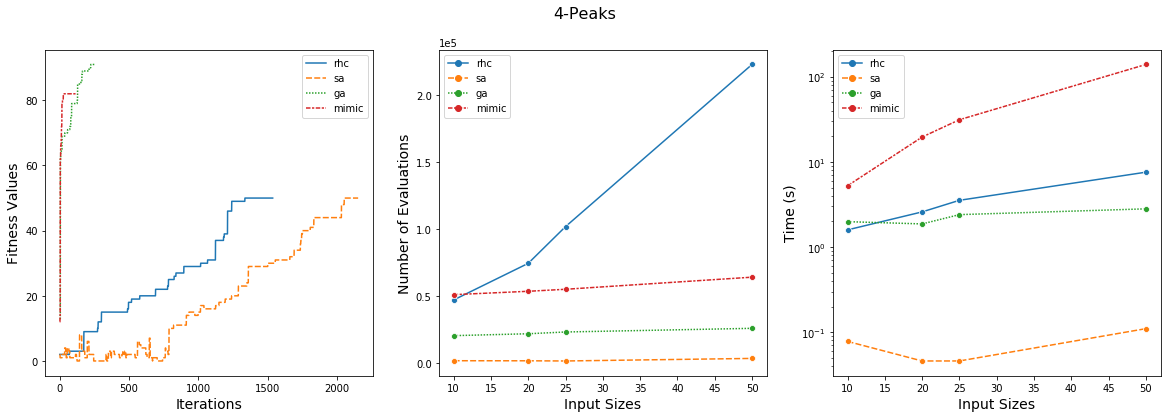

In [118]:
fig = plt.figure(figsize=(20,6))
# fig, axes = plt.subplots(1, 3, figsize=(20,4))
fig.suptitle(title, fontsize=16)

## evaluation number
df = eval_cnt_df.set_index('input_size')
ax = fig.add_subplot(132)
ax = sns.lineplot(data=df, markers=['o']*4,)
ax.ticklabel_format(axis='y', style='sci',  scilimits=(0,0))
ax.set_xlabel('Input Sizes', fontsize=14)
ax.set_ylabel('Number of Evaluations',fontsize=14)

## time
df = eval_time_df.set_index('input_size')
ax = fig.add_subplot(133)
ax = sns.lineplot(data=df, markers=['o']*4)
ax.set_yscale('log')
ax.set_xlabel('Input Sizes', fontsize=14)
ax.set_ylabel('Time (s)', fontsize=14)

## Fitness Convergence Analysis
labels = ['rhc', 'sa', 'ga', 'mimic']
az = fig.add_subplot(131)
ax = sns.lineplot(data=[rhc_curve, sa_curve, ga_curve, mimic_curve])
# ax.set_ylim(0, 36)
ax.set_xlabel('Iterations', fontsize=14)
ax.set_ylabel('Fitness Values', fontsize=14)
legend = ax.get_legend()
for handle,l in zip(legend.texts, labels):
    handle.set_text(l)

# plt.tight_layout(True)